#Import data

In [323]:
import numpy as np
import pandas as pd
from time import time

data = pd.read_csv('BTC-USD.csv', index_col = 'Date')
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-15,16617.484375,17051.962891,16542.550781,16884.613281,16884.613281,36599436183
2022-11-16,16884.341797,16960.294922,16430.111328,16669.439453,16669.439453,33925512989
2022-11-17,16670.425781,16726.439453,16460.683594,16687.517578,16687.517578,27868914022
2022-11-18,16687.912109,16947.058594,16564.611328,16697.777344,16697.777344,26862218609
2022-11-19,16694.867188,16694.867188,16573.224609,16638.134766,16638.134766,15707914240


#Preprocessing

In [324]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set = data.iloc[:,0:4]
training_set_scaled = sc.fit_transform(training_set.values)

#**Dự đoán theo ngày**

In [325]:
X = []
y = []
for i in range(60, len(training_set_scaled)):
    X.append(training_set_scaled[i-60:i])
    y.append(training_set_scaled[i])
X, y = np.array(X), np.array(y)

split_index = int(np.ceil(len(X)*0.8))
date_index = data.index
X_train, X_test = X[:split_index], X[split_index:-14]
y_train, y_test = y[:split_index], y[split_index:]
X_val , y_val = X[split_index:split_index+100], y[split_index:split_index+100]
X_train_date, X_test_date = date_index[:split_index], date_index[split_index:]
print(X.shape, X_train.shape, y_train.shape)

(1037, 60, 4) (830, 60, 4) (830, 4)


In [326]:
X_train_2dims = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_2dims = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

#LSTM Model

In [327]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [328]:
lstm = Sequential()
lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
lstm.add(LSTM(units = 64, return_sequences = False))
lstm.add(Dense(units = 4))

lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
lstm.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data=(X_val, y_val))
end = time()
training_time_lstm = end - start
lstm.build(X_train.shape)
lstm.summary()

Epoch 1/10
26/26 [==============================] - 8s 113ms/step - loss: 0.2510 - val_loss: 0.0407
Epoch 2/10
26/26 [==============================] - 2s 73ms/step - loss: 0.0381 - val_loss: 0.0211
Epoch 3/10
26/26 [==============================] - 2s 71ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 4/10
26/26 [==============================] - 2s 72ms/step - loss: 0.0208 - val_loss: 0.0261
Epoch 5/10
26/26 [==============================] - 2s 72ms/step - loss: 0.0184 - val_loss: 0.0232
Epoch 6/10
26/26 [==============================] - 2s 70ms/step - loss: 0.0174 - val_loss: 0.0220
Epoch 7/10
26/26 [==============================] - 2s 69ms/step - loss: 0.0160 - val_loss: 0.0229
Epoch 8/10
26/26 [==============================] - 2s 70ms/step - loss: 0.0141 - val_loss: 0.0205
Epoch 9/10
26/26 [==============================] - 2s 71ms/step - loss: 0.0125 - val_loss: 0.0219
Epoch 10/10
26/26 [==============================] - 2s 72ms/step - loss: 0.0119 - val_loss: 0.0193
Model: "

In [329]:
X_test_lstm = X_test
start = time()
for i in range(14):
  y_pred_lstm = lstm.predict(X_test_lstm)
  X_14d = np.concatenate((X_test_lstm[-1, 1:, :], y_pred_lstm[-1,:].reshape((1,4))))
  X_test_lstm = np.concatenate((X_test_lstm, X_14d.reshape(1,60,4)))
end = time()
testing_time_lstm = end - start

7/7 [==============================] - 0s 19ms/step


#MLP

In [330]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=8, max_iter = 35, activation='relu', solver ='sgd', learning_rate = 'invscaling')
start = time()
mlp.fit(X_train_2dims, y_train)
end = time()
training_time_mlp = end - start

In [331]:
X_test_mlp = X_test_2dims
start = time()
for i in range(14):
  y_pred_mlp = mlp.predict(X_test_mlp)
  X_14d = np.concatenate((X_test_mlp[-1, 4:], y_pred_mlp[-1,:].reshape((4))))
  X_test_mlp = np.concatenate((X_test_mlp, X_14d.reshape(1,240)))
end = time()
testing_time_mlp = end - start

#RNN

In [332]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
rnn.add(SimpleRNN(units = 32, return_sequences = False))
rnn.add(Dense(units = 4))

rnn.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
rnn.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data=(X_val, y_val))
end = time()
training_time_rnn = end - start
rnn.build(X_train.shape)
rnn.summary()

Epoch 1/10
26/26 [==============================] - 3s 38ms/step - loss: 0.1459 - val_loss: 0.0588
Epoch 2/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0236 - val_loss: 0.0434
Epoch 3/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0136 - val_loss: 0.0226
Epoch 4/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0109 - val_loss: 0.0200
Epoch 5/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0092 - val_loss: 0.0298
Epoch 6/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0090 - val_loss: 0.0273
Epoch 7/10
26/26 [==============================] - 1s 25ms/step - loss: 0.0079 - val_loss: 0.0178
Epoch 8/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0072 - val_loss: 0.0160
Epoch 9/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0066 - val_loss: 0.0161
Epoch 10/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0064 - val_loss: 0.0121
Model: "s

In [333]:
X_test_rnn = X_test
start = time()
for i in range(14):
  y_pred_rnn = rnn.predict(X_test_rnn)
  X_14d = np.concatenate((X_test_rnn[-1, 1:, :], y_pred_rnn[-1,:].reshape((1,4))))
  X_test_rnn = np.concatenate((X_test_rnn, X_14d.reshape(1,60,4)))
end = time()
testing_time_rnn = end - start

7/7 [==============================] - 0s 7ms/step


#SVM

In [334]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr = MultiOutputRegressor(SVR())
start = time()
svr.fit(X_train_2dims, y_train)
end = time()
training_time_svr = end - start

In [335]:
X_test_svr = X_test_2dims
start = time()
for i in range(14):
  y_pred_svr = svr.predict(X_test_svr)
  X_14d = np.concatenate((X_test_svr[-1, 4:], y_pred_svr[-1,:].reshape((4))))
  X_test_svr = np.concatenate((X_test_svr, X_14d.reshape(1,240)))
end = time()
testing_time_svr = end - start

#kNN

In [336]:
from sklearn.neighbors import KNeighborsRegressor

kNN = KNeighborsRegressor()
start = time()
kNN.fit(X_train_2dims, y_train)
end = time()
training_time_kNN = end - start

In [337]:
X_test_kNN = X_test_2dims
start = time()
for i in range(14):
  y_pred_kNN = kNN.predict(X_test_kNN)
  X_14d = np.concatenate((X_test_kNN[-1, 4:], y_pred_kNN[-1,:].reshape((4))))
  X_test_kNN = np.concatenate((X_test_kNN, X_14d.reshape(1,240)))
end = time()
testing_time_kNN = end - start

#Linear Regression

In [338]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
start = time()
lr.fit(X_train_2dims, y_train)
end = time()
training_time_lr = end - start

In [339]:
X_test_lr = X_test_2dims
start = time()
for i in range(14):
  y_pred_lr = lr.predict(X_test_lr)
  X_14d = np.concatenate((X_test_lr[-1, 4:], y_pred_lr[-1,:].reshape((4))))
  X_test_lr = np.concatenate((X_test_lr, X_14d.reshape(1,240)))
end = time()
testing_time_lr = end - start

#Decision Tree

In [340]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
start = time()
dt.fit(X_train_2dims, y_train)
end = time()
training_time_dt = end - start

In [341]:
X_test_dt = X_test_2dims
start = time()
for i in range(14):
  y_pred_dt = lr.predict(X_test_dt)
  X_14d = np.concatenate((X_test_dt[-1, 4:], y_pred_dt[-1,:].reshape((4))))
  X_test_dt = np.concatenate((X_test_dt, X_14d.reshape(1,240)))
end = time()
testing_time_dt = end - start

#Transform

In [342]:
y_pred_lstm = sc.inverse_transform(y_pred_lstm)
y_pred_rnn = sc.inverse_transform(y_pred_rnn)
y_pred_svr = sc.inverse_transform(y_pred_svr)
y_pred_mlp = sc.inverse_transform(y_pred_mlp)
y_pred_kNN = sc.inverse_transform(y_pred_kNN)
y_pred_lr = sc.inverse_transform(y_pred_lr)
y_pred_dt = sc.inverse_transform(y_pred_dt)
y_test = sc.inverse_transform(y_test)

#Đồ thị ngày (Dự đoán 14 ngày tiếp theo)

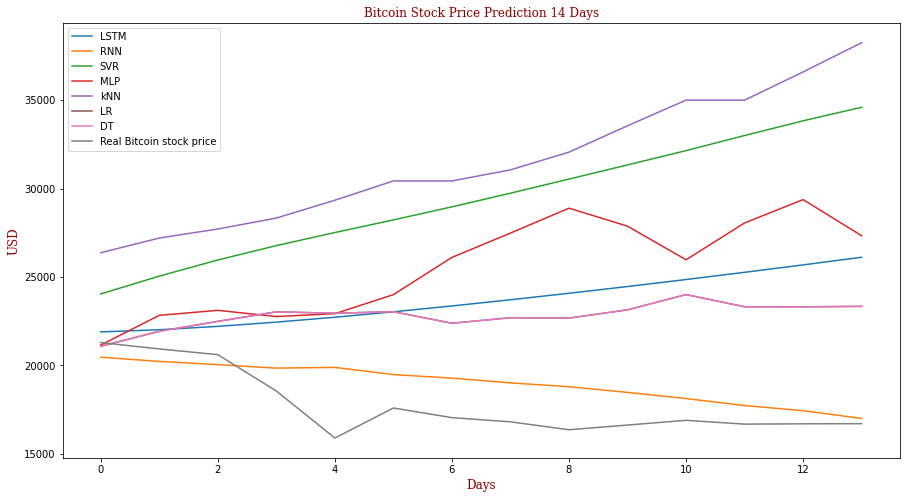

In [343]:
import matplotlib.pyplot as plt
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }
plt.figure(figsize = (15,8))
plt.title('Bitcoin Stock Price Prediction 14 Days', fontdict=font)
plt.xlabel('Days', fontdict=font)
plt.ylabel('USD', fontdict=font)
plt.plot(y_pred_lstm[-14:,0], label = 'LSTM')
plt.plot(y_pred_rnn[-14:,0], label = 'RNN')
plt.plot(y_pred_svr[-14:,0], label = 'SVR')
plt.plot(y_pred_mlp[-14:,0], label = 'MLP')
plt.plot(y_pred_kNN[-14:,0], label = 'kNN')
plt.plot(y_pred_lr[-14:,0], label = 'LR')
plt.plot(y_pred_dt[-14:,0], label = 'DT')
plt.plot(y_test[-14:,0], label = 'Real Bitcoin stock price')
plt.legend()
plt.show()

#So sánh thời gian Training

In [372]:
print("LSTM: ", training_time_lstm)
print("SVR: ", training_time_svr)
print("Linear Regression: ", training_time_lr)
print("MLP: ", training_time_mlp)
print("RNN: ", training_time_rnn)
print("kNN: ", training_time_kNN)
print("Decision Tree: ", training_time_dt)

LSTM:  24.344502687454224
SVR:  0.11846733093261719
Linear Regression:  0.07486772537231445
MLP:  0.06974244117736816
RNN:  8.825072765350342
kNN:  0.0009632110595703125
Decision Tree:  0.17736554145812988


#So sánh thời gian Testing

In [373]:
print("LSTM: ", testing_time_lstm)
print("SVR: ", testing_time_svr)
print("Linear Regression: ", testing_time_lr)
print("MLP: ", testing_time_mlp)
print("RNN: ", testing_time_rnn)
print("kNN: ", testing_time_kNN)
print("Decision Tree: ", testing_time_dt)

LSTM:  4.699127912521362
SVR:  0.4390895366668701
Linear Regression:  0.013092994689941406
MLP:  0.010719776153564453
RNN:  2.1903939247131348
kNN:  0.1037907600402832
Decision Tree:  0.008199214935302734


#So sánh MSE theo đồ thị ngày

In [344]:
from sklearn.metrics import mean_squared_error

print("LSTM: ", mean_squared_error(y_pred_lstm[-14:], y_test[-14:]))
print("SVR: ", mean_squared_error(y_pred_svr[-14:], y_test[-14:]))
print("Linear Regression: ", mean_squared_error(y_pred_lr[-14:], y_test[-14:]))
print("MLP: ", mean_squared_error(y_pred_mlp[-14:], y_test[-14:]))
print("RNN: ", mean_squared_error(y_pred_rnn[-14:], y_test[-14:]))
print("kNN: ", mean_squared_error(y_pred_kNN[-14:], y_test[-14:]))
print("Decision Tree: ", mean_squared_error(y_pred_dt[-14:], y_test[-14:]))

LSTM:  45406261.46286681
SVR:  170681354.88993704
Linear Regression:  32516135.640917353
MLP:  126998281.44868317
RNN:  3857501.155911948
kNN:  232030261.86620915
Decision Tree:  32516135.640917353


#**Dự đoán theo tuần**

#Biến đổi dữ liệu theo tuần

In [345]:
import statistics as stt

X_week = []
y_week = []
data_week = []
for i in range(0, len(training_set), 7):
  a = stt.mean(training_set.values[i:i+7,0])
  b = np.max(training_set.values[i:i+7,1])
  c = np.min(training_set.values[i:i+7,2])
  d = stt.mean(training_set.values[i:i+7,3])
  data_week.append([a,b,c,d])
data_week = np.array(sc.transform(data_week))
print(data_week.shape)

for i in range(5, len(data_week)):
    X_week.append(data_week[i-5:i])
    y_week.append(data_week[i])
X_week, y_week = np.array(X_week), np.array(y_week)
print(X_week.shape, y_week.shape)

(157, 4)
(152, 5, 4) (152, 4)


In [346]:
split_index = int(np.ceil(len(X_week)*0.8))
X_week_train, X_week_test = X_week[:split_index], X_week[split_index:-7]
y_week_train, y_week_test = y_week[:split_index], y_week[split_index:]
X_week_val , y_week_val = X_week[split_index:split_index+10], y_week[split_index:split_index+10]
print(X_week.shape, X_week_test.shape, y_week_train.shape)

(152, 5, 4) (23, 5, 4) (122, 4)


#LSTM

In [347]:
lstm_week = Sequential()
lstm_week.add(LSTM(units = 32, return_sequences = True, input_shape = (X_week_train.shape[1], X_week_train.shape[2])))
lstm_week.add(LSTM(units = 32, return_sequences = False))
lstm_week.add(Dense(units = 4))

lstm_week.compile(optimizer = 'adam', loss = 'mean_squared_error')

start = time()
lstm_week.fit(X_week_train, y_week_train, epochs = 10, batch_size = 32, validation_data=(X_week_val, y_week_val))
end = time()
training_time_lstm_week = end - start
lstm_week.build(X_week_train.shape)
lstm_week.summary()

Epoch 1/10
4/4 [==============================] - 5s 522ms/step - loss: 1.1079 - val_loss: 0.1119
Epoch 2/10
4/4 [==============================] - 0s 14ms/step - loss: 0.9688 - val_loss: 0.1022
Epoch 3/10
4/4 [==============================] - 0s 15ms/step - loss: 0.8298 - val_loss: 0.0968
Epoch 4/10
4/4 [==============================] - 0s 16ms/step - loss: 0.6852 - val_loss: 0.0986
Epoch 5/10
4/4 [==============================] - 0s 15ms/step - loss: 0.5256 - val_loss: 0.1155
Epoch 6/10
4/4 [==============================] - 0s 14ms/step - loss: 0.3810 - val_loss: 0.1617
Epoch 7/10
4/4 [==============================] - 0s 14ms/step - loss: 0.2557 - val_loss: 0.2430
Epoch 8/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1857 - val_loss: 0.3401
Epoch 9/10
4/4 [==============================] - 0s 20ms/step - loss: 0.1517 - val_loss: 0.3916
Epoch 10/10
4/4 [==============================] - 0s 17ms/step - loss: 0.1353 - val_loss: 0.3911
Model: "sequential_32"
_____

In [348]:
X_test_lstm_week = X_week_test
start = time()
for i in range(7):
  y_week_pred_lstm = lstm_week.predict(X_test_lstm_week)
  X_7w = np.concatenate((X_test_lstm_week[-1, 1:, :], y_week_pred_lstm[-1,:].reshape((1,4))))
  X_test_lstm_week = np.concatenate((X_test_lstm_week, X_7w.reshape(1,5,4)))
end = time()
testing_time_lstm_week = end - start

1/1 [==============================] - 0s 19ms/step


#MLP

In [349]:
X_week_train_2dims = X_week_train.reshape((X_week_train.shape[0], X_week_train.shape[1]*X_week_train.shape[2]))
X_week_test_2dims = X_week_test.reshape((X_week_test.shape[0], X_week_test.shape[1]*X_week_test.shape[2]))

In [350]:
mlp_week = MLPRegressor(hidden_layer_sizes=8, activation='relu', solver='sgd', learning_rate = 'invscaling')
start = time()
mlp_week.fit(X_week_train_2dims, y_week_train)
end = time()
training_time_mlp_week = end - start

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [351]:
X_week_test_mlp = X_week_test_2dims
start = time()
for i in range(7):
  y_week_pred_mlp = mlp_week.predict(X_week_test_mlp)
  X_7w = np.concatenate((X_week_test_mlp[-1, 4:], y_week_pred_mlp[-1,:].reshape((4))))
  X_week_test_mlp = np.concatenate((X_week_test_mlp, X_7w.reshape(1,20)))
end = time()
testing_time_mlp_week = end - start

#RNN

In [352]:
rnn_week = Sequential()
rnn_week.add(SimpleRNN(units = 64, return_sequences = True, input_shape = (X_week_train.shape[1], X_week_train.shape[2])))
rnn_week.add(SimpleRNN(units = 32, return_sequences = False))
rnn_week.add(Dense(units = 4))

rnn_week.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time()
rnn_week.fit(X_week_train, y_week_train, epochs = 10, batch_size = 32, validation_data=(X_week_val, y_week_val))
end = time()
training_time_rnn_week = end - start
rnn_week.build(X_week_train.shape)

Epoch 1/10
4/4 [==============================] - 2s 119ms/step - loss: 0.2897 - val_loss: 0.3925
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.1448 - val_loss: 0.3994
Epoch 3/10
4/4 [==============================] - 0s 13ms/step - loss: 0.1363 - val_loss: 0.3885
Epoch 4/10
4/4 [==============================] - 0s 11ms/step - loss: 0.1096 - val_loss: 0.2614
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0841 - val_loss: 0.1947
Epoch 6/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0752 - val_loss: 0.1795
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 0.0684 - val_loss: 0.1433
Epoch 8/10
4/4 [==============================] - 0s 11ms/step - loss: 0.0592 - val_loss: 0.1481
Epoch 9/10
4/4 [==============================] - 0s 14ms/step - loss: 0.0542 - val_loss: 0.1398
Epoch 10/10
4/4 [==============================] - 0s 16ms/step - loss: 0.0512 - val_loss: 0.1157


In [353]:
X_test_rnn_week = X_week_test
start = time()
for i in range(7):
  y_week_pred_rnn = rnn_week.predict(X_test_rnn_week)
  X_7w = np.concatenate((X_test_rnn_week[-1, 1:, :], y_week_pred_rnn[-1,:].reshape((1,4))))
  X_test_rnn_week = np.concatenate((X_test_rnn_week, X_7w.reshape(1,5,4)))
end = time()
testing_time_rnn_week = end - start


1/1 [==============================] - 0s 18ms/step


#SVM

In [354]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr_week = MultiOutputRegressor(SVR())
start = time()
svr_week.fit(X_week_train_2dims, y_week_train)
end = time()
training_time_svr_week = end - start

In [355]:
X_week_test_svr = X_week_test_2dims
start = time()
for i in range(7):
  y_week_pred_svr = svr_week.predict(X_week_test_svr)
  X_7w = np.concatenate((X_week_test_svr[-1, 4:], y_week_pred_svr[-1,:].reshape((4))))
  X_week_test_svr = np.concatenate((X_week_test_svr, X_7w.reshape(1,20)))
end = time()
testing_time_svr_week = end - start

#kNN

In [356]:
kNN_week = KNeighborsRegressor()
start = time()
kNN_week.fit(X_week_train_2dims, y_week_train)
end = time()
training_time_kNN_week = end - start

In [357]:
X_week_test_kNN = X_week_test_2dims
start = time()
for i in range(7):
  y_week_pred_kNN = kNN_week.predict(X_week_test_kNN)
  X_7w = np.concatenate((X_week_test_kNN[-1, 4:], y_week_pred_kNN[-1,:].reshape((4))))
  X_week_test_kNN = np.concatenate((X_week_test_kNN, X_7w.reshape(1,20)))
end = time()
testing_time_kNN_week = end - start

#Decision Tree

In [358]:
dt_week = DecisionTreeRegressor()
start = time()
dt_week.fit(X_week_train_2dims, y_week_train)
end = time()
training_time_dt_week = end - start

In [359]:
X_week_test_dt = X_week_test_2dims
start = time()
for i in range(7):
  y_week_pred_dt = dt_week.predict(X_week_test_dt)
  X_7w = np.concatenate((X_week_test_dt[-1, 4:], y_week_pred_dt[-1,:].reshape((4))))
  X_week_test_dt = np.concatenate((X_week_test_dt, X_7w.reshape(1,20)))
end = time()
testing_time_dt_week = end - start

#Linear Regression

In [360]:
lr_week = LinearRegression()
start = time()
lr_week.fit(X_week_train_2dims, y_week_train)
end = time()
training_time_lr_week = end - start

In [361]:
X_week_test_lr = X_week_test_2dims
start = time()
for i in range(7):
  y_week_pred_lr = lr_week.predict(X_week_test_lr)
  X_7w = np.concatenate((X_week_test_lr[-1, 4:], y_week_pred_lr[-1,:].reshape((4))))
  X_week_test_lr = np.concatenate((X_week_test_lr, X_7w.reshape(1,20)))
end = time()
testing_time_lr_week = end - start

#Inverse Transform

In [362]:
y_week_pred_lstm = sc.inverse_transform(y_week_pred_lstm)
y_week_test = sc.inverse_transform(y_week_test)
y_week_pred_mlp = sc.inverse_transform(y_week_pred_mlp)
y_week_pred_rnn = sc.inverse_transform(y_week_pred_rnn)
y_week_pred_kNN = sc.inverse_transform(y_week_pred_kNN)
y_week_pred_lr = sc.inverse_transform(y_week_pred_lr)
y_week_pred_dt = sc.inverse_transform(y_week_pred_dt)
y_week_pred_svr = sc.inverse_transform(y_week_pred_svr)

#Đồ thị tuần (Dự đoán 7 tuần tiếp theo)

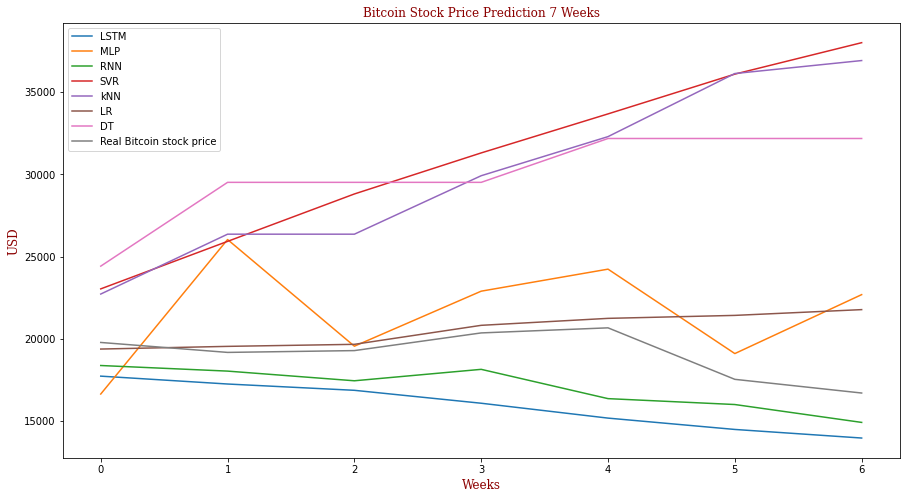

In [363]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }
plt.figure(figsize = (15,8))
plt.title('Bitcoin Stock Price Prediction 7 Weeks', fontdict=font)
plt.xlabel('Weeks', fontdict=font)
plt.ylabel('USD', fontdict=font)
plt.plot(y_week_pred_lstm[-7:,0], label = 'LSTM')
plt.plot(y_week_pred_mlp[-7:,0], label = 'MLP')
plt.plot(y_week_pred_rnn[-7:,0], label = 'RNN')
plt.plot(y_week_pred_svr[-7:,0], label = 'SVR')
plt.plot(y_week_pred_kNN[-7:,0], label = 'kNN')
plt.plot(y_week_pred_lr[-7:,0], label = 'LR')
plt.plot(y_week_pred_dt[-7:,0], label = 'DT')
plt.plot(y_week_test[-7:,0], label = 'Real Bitcoin stock price')
plt.legend()
plt.show()

#So sánh thời gian Training

In [369]:
print("LSTM: ", training_time_lstm_week)
print("SVR: ", training_time_svr_week)
print("Linear Regression: ", training_time_lr_week)
print("MLP: ", training_time_mlp_week)
print("RNN: ", training_time_rnn_week)
print("kNN: ", training_time_kNN_week)
print("Decision Tree: ", training_time_dt_week)

LSTM:  6.1341776847839355
SVR:  0.010627985000610352
Linear Regression:  0.0020546913146972656
MLP:  0.1069333553314209
RNN:  2.4401466846466064
kNN:  0.0008513927459716797
Decision Tree:  0.00398564338684082


#So sánh thời gian Testing

In [370]:
print("LSTM: ", testing_time_lstm_week)
print("SVR: ", testing_time_svr_week)
print("Linear Regression: ", testing_time_lr_week)
print("MLP: ", testing_time_mlp_week)
print("RNN: ", testing_time_rnn_week)
print("kNN: ", testing_time_kNN_week)
print("Decision Tree: ", testing_time_dt_week)

LSTM:  1.3416192531585693
SVR:  0.015671968460083008
Linear Regression:  0.003014087677001953
MLP:  0.002686023712158203
RNN:  0.6729025840759277
kNN:  0.008563756942749023
Decision Tree:  0.001771688461303711


#So sánh MSE của các model theo đồ thị tuần

In [365]:
print("LSTM: ", mean_squared_error(y_week_pred_lstm[-7:], y_week_test[-7:]))
print("SVR: ", mean_squared_error(y_week_pred_svr[-7:], y_week_test[-7:]))
print("Linear Regression: ", mean_squared_error(y_week_pred_lr[-7:], y_week_test[-7:]))
print("MLP: ", mean_squared_error(y_week_pred_mlp[-7:], y_week_test[-7:]))
print("RNN: ", mean_squared_error(y_week_pred_rnn[-7:], y_week_test[-7:]))
print("kNN: ", mean_squared_error(y_week_pred_kNN[-7:], y_week_test[-7:]))
print("Decision Tree: ", mean_squared_error(y_week_pred_dt[-7:], y_week_test[-7:]))

LSTM:  8049704.500351002
SVR:  192695364.27619964
Linear Regression:  6325133.990570074
MLP:  73397954.66213855
RNN:  8379791.932399608
kNN:  160080514.74430302
Decision Tree:  135383113.70457017
